Looking into extracting what is useful about the Linear component - maybe the slope?

In [2]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from pymc3.gp.util import plot_gp_dist
%matplotlib inline

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [3]:
train_df = pd.read_csv("Dataset/train.csv")
test_df = pd.read_csv("Dataset/test.csv")

In [4]:
headers = train_df.iloc[:,1:-1].columns.values
X = np.array([int(i) for i in headers])[:,None]  # this is ridiculous way of getting array [0,1,....,99]

In [5]:
y = train_df.iloc[:,1:-1].to_numpy()  # the data

In [6]:
increasing = train_df.iloc[:,-1:]['Category'].to_numpy()  # the target

Until I get the hang of this, I'm running through all the below steps for just a single ice-cream shop. Fix the `index` here:

In [18]:
index = 14

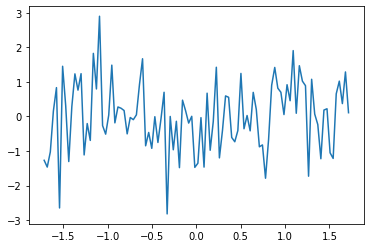

In [19]:
# scale data to make more numerically stable
mean = np.mean(y[index,:])
std = np.std(y[index,:])
yy = (y[index,:]-mean)/std  #standard scaler

XX = (X-np.mean(X))/np.std(X)

plt.plot(XX, yy)

Running PyMC3, isolating just a linear and periodic component. I'm not (yet) tempted to isolate anything else, as I'm expecting to only really care about the slope of the linear component. If slope greater than some threshold (to be found), then perhaps it matches with the `increasing` target?

In [20]:
with pm.Model() as model:
    #  generic component x 
    η_s = pm.HalfCauchy("η_s", beta=5, testval=1)
    ℓ_smooth = pm.Gamma("ℓ_smooth ", alpha=1, beta=1 )
    cov_generic = η_s**2 * pm.gp.cov.ExpQuad(1, ℓ_smooth)     
    gp1 = pm.gp.Marginal(cov_func=cov_generic)
    
    #  periodic component x 
    η_per = pm.HalfCauchy("η_per", beta=5, testval=1)
    #period  = pm.Normal("period", mu=1, sigma=2)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=1, beta=1)
    η_matern = pm.HalfCauchy("η_matern", beta=5, testval=1)
    cov_seasonal = η_per**2 * pm.gp.cov.Cosine(1,  ℓ_psmooth) * pm.gp.cov.Matern32(1, η_matern)    
    gp2 = pm.gp.Marginal(cov_func=cov_seasonal)
    
    #  linear component x 
    tau = pm.HalfCauchy("tau", beta=2, testval=1.0)
    c  = pm.Normal("c", mu=0, sigma=1) 
    
    cov_linear = tau * pm.gp.cov.Linear(1, c)
    gp3 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2.
    gp = gp1 + gp2 + gp3
    

    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
    f = gp.marginal_likelihood("f", XX, yy, noise=sigma)
    
    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

/home/gerry/.local/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -151.61, ||grad|| = 0.00062341: 100%|██████████| 65/65 [00:00<00:00, 155.43it/s]  


In [21]:
mp

{'η_s_log__': array(-1.2638291, dtype=float32),
 'ℓ_smooth _log__': array(-1.7543504, dtype=float32),
 'η_per_log__': array(-121.708206, dtype=float32),
 'ℓ_psmooth _log__': array(-13.699314, dtype=float32),
 'η_matern_log__': array(-71.26725, dtype=float32),
 'tau_log__': array(-370.3793, dtype=float32),
 'c': array(0.00054134, dtype=float32),
 'sigma_log__': array(-0.04126888, dtype=float32),
 'η_s': array(0.28256997, dtype=float32),
 'ℓ_smooth ': array(0.17301959, dtype=float32),
 'η_per': array(0., dtype=float32),
 'ℓ_psmooth ': array(1.1232165e-06, dtype=float32),
 'η_matern': array(1.1195064e-31, dtype=float32),
 'tau': array(0., dtype=float32),
 'sigma': array(0.95957106, dtype=float32)}

Plot the predictions and actual data, with & without predicted noise

### How well does whole model map to the data?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


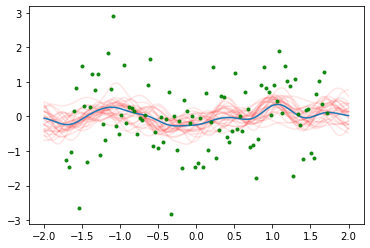

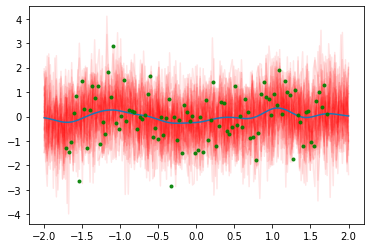

In [22]:
# 200 new values from x=0 to x=100
n_new = 200
X_new = np.linspace(-2, 2, n_new)[:,None]

#generic term
f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma})
y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma}, pred_noise=True)
#periodic term
f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma})
y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma}, pred_noise=True)
#linear term
f3_pred = gp3.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma})
y3_pred = gp3.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma}, pred_noise=True)
#sum of periodic and linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": XX, "y": yy, "noise": sigma})

sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0], sample_f.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f_pred[0])# this is the average line
plt.plot(XX, yy, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

plt.figure()
#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0], y_pred[1]).rvs(30)

plt.plot(X_new[:,0], sample_y.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f_pred[0])# this is the average line
plt.plot(XX, yy, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

### Generic component

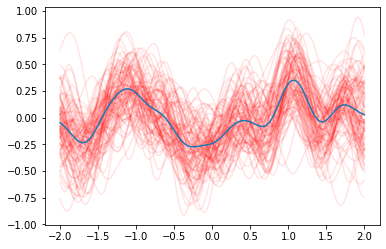

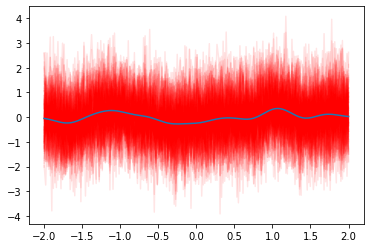

In [23]:
#we sample 100 regression lines from the posterior
sample_f1 = multivariate_normal(f1_pred[0],f1_pred[1]).rvs(100)

plt.plot(X_new[:,0], sample_f1.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f1_pred[0])# this is the average line

plt.figure()
#we sample 100 regression lines from the posterior
sample_y1 = multivariate_normal(y1_pred[0], y1_pred[1]).rvs(100)

plt.plot(X_new[:,0], sample_y1.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f1_pred[0])# this is the average line

## Periodic component

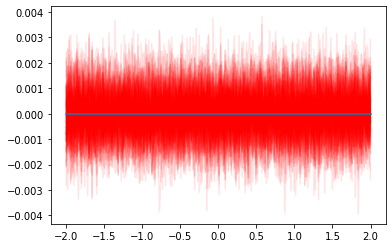

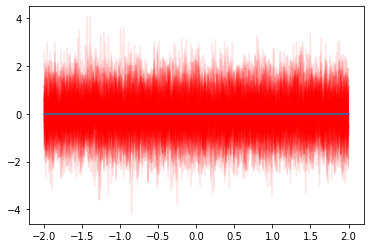

In [24]:
#we sample 100 regression lines from the posterior
sample_f2 = multivariate_normal(f2_pred[0],f2_pred[1]).rvs(100)

plt.plot(X_new[:,0], sample_f2.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f2_pred[0])# this is the average line

plt.figure()
#we sample 100 regression lines from the posterior
sample_y2 = multivariate_normal(y2_pred[0], y2_pred[1]).rvs(100)

plt.plot(X_new[:,0], sample_y2.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f2_pred[0])# this is the average line

### Linear component

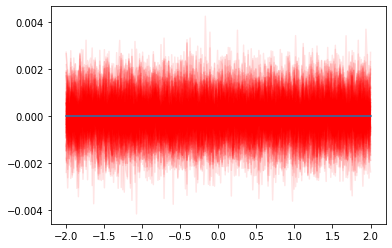

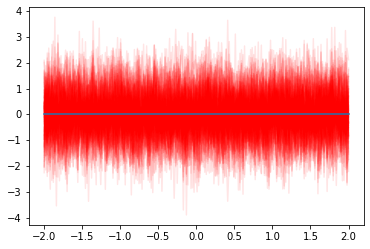

In [25]:
#we sample 100 regression lines from the posterior
sample_f3 = multivariate_normal(f3_pred[0],f3_pred[1]).rvs(100)

plt.plot(X_new[:,0], sample_f3.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f3_pred[0])# this is the average line

plt.figure()
#we sample 100 regression lines from the posterior
sample_y3 = multivariate_normal(y3_pred[0], y3_pred[1]).rvs(100)

plt.plot(X_new[:,0], sample_y3.T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], f3_pred[0])# this is the average line

## Generic + Linear component

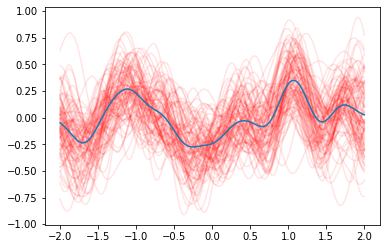

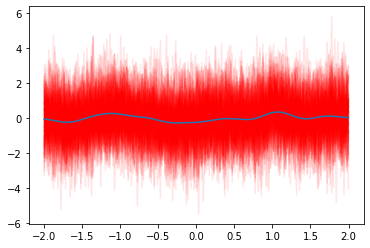

In [26]:
plt.plot(X_new[:,0], (sample_f1 + sample_f3).T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], (f1_pred[0] + f3_pred[0])) # this is the average line

plt.figure()

plt.plot(X_new[:,0], (sample_y1 + sample_y3).T, color='red', alpha=0.1)# regression lines
plt.plot(X_new[:,0], (f1_pred[0] + f3_pred[0])) # this is the average line

The Generic+Linear combined should express the sales of icecream, once the seasonal adjustments are removed.

I want to find out if the slope of this graph is *ever* negative, as that would indicate sales decreased at some stage

In [27]:
Gradients = []
for i in range(sample_f1.shape[0]):
    Gradients.append(np.min(np.gradient(sample_f1[i,:] + sample_f3[i,:])))

    
posterior_probability_deriviative_is_negative = len(np.where(np.array(Gradients) < 0)[0])/len(Gradients)
print("probability that the function ever decreased=", posterior_probability_deriviative_is_negative)
if posterior_probability_deriviative_is_negative > 0.05:
    print("Is *not* strictly increasing - return 0")
else:
    print("Is strictly increasing! - return 1")

probability that the function ever decreased= 1.0
Is *not* strictly increasing


In [28]:
increasing[index]

0

## IGNORE BELOW

In [132]:
(y2_pred[0][-1] - y2_pred[0][0]) / 100  #(proportional to) the slope of the linear component

-0.001813507262868702

Try again, this time setting `index = 0` to compare the calculated slope with this. I get a small number.

In [133]:
sample_f2 = multivariate_normal(f2_pred[0],f2_pred[1]).rvs(1000)

sample_f2[0]

array([ 0.16838905,  0.26675958,  0.36093449,  0.44832213,  0.53430055,
        0.6131673 ,  0.68204391,  0.74659185,  0.79944544,  0.84409192,
        0.87880466,  0.90594853,  0.9172565 ,  0.92213472,  0.91534469,
        0.89511522,  0.86591556,  0.82810561,  0.77962143,  0.7234634 ,
        0.65644638,  0.58301935,  0.50405403,  0.4149913 ,  0.32591384,
        0.23091488,  0.13293874,  0.03262766, -0.06433105, -0.16363284,
       -0.25961403, -0.35538058, -0.44504793, -0.52905953, -0.60886093,
       -0.67966856, -0.74103067, -0.79655632, -0.84191881, -0.87818389,
       -0.90261861, -0.91836332, -0.92200688, -0.91674062, -0.8970487 ,
       -0.86952208, -0.8296041 , -0.78178777, -0.72619977, -0.66220751,
       -0.58905299, -0.50833298, -0.41961694, -0.33177562, -0.23619404,
       -0.13915035, -0.04075411,  0.06195175,  0.15925226,  0.25543244,
        0.35153961,  0.4399222 ,  0.52619021,  0.60388356,  0.67547719,
        0.73696897,  0.79395613,  0.83974835,  0.87575592,  0.90

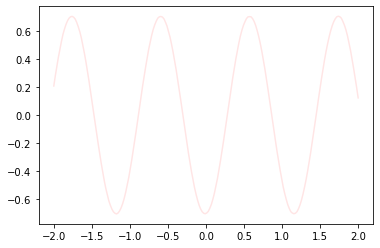

In [134]:
plt.plot(X_new[:,0], sample_f2[2], color='red', alpha=0.1)# regression lines


### Fraction of the sampled lines that have slope > 0

In [389]:
def get_slope(line_array):
    return (line_array[-1] - line_array[0] ) / 100
        
slopes = get_slope(sample_f2.T)
np.count_nonzero( slopes > 0 ) / len(slopes)

0.738

  0%|          | 0/10000 [00:00<?, ?it/s]/home/gerry/.local/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 109.04: 100%|██████████| 10000/10000 [00:38<00:00, 258.21it/s]
Finished [100%]: Average Loss = 108.93
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


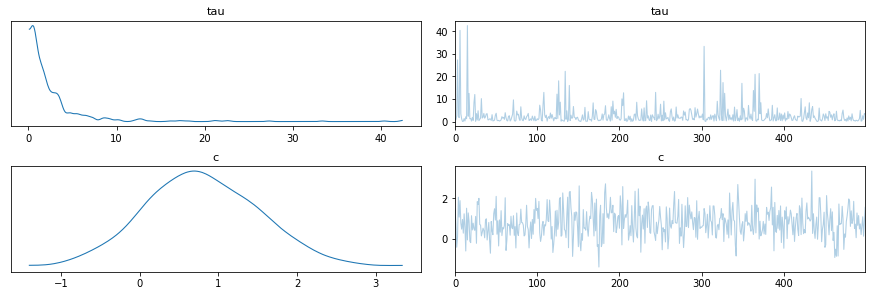

In [335]:
#with model:
#    posterior = pm.sample(500, tune=500, chains=1)


#we can do  an approximated inference
with model:
    inference = pm.ADVI()
    approx = pm.fit(10000, method=inference)


posterior = approx.sample(draws=500)

#pm.traceplot(tr)
pm.plot_trace(posterior, var_names=['tau', 'c']);

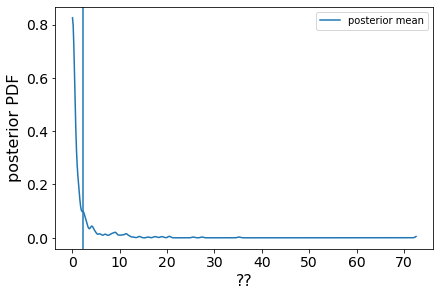

In [193]:
import arviz as az

posterior_mean=np.mean(posterior['tau'],axis=0)
a = posterior['tau'] #[posterior['tau'] < 50]  # remove outliers?

az.plot_dist(a)
plt.xlabel("??", fontsize=16)
plt.ylabel("posterior PDF", fontsize=16)
plt.axvline(posterior_mean,label='posterior mean')
#plt.axvline(clf.coef_[0,:],label='MLE estimate (Sklearn)',color='g')
plt.legend()